# Importing Dataset

In [ ]:
# Insert Kaggle username and key 
import os
os.environ['KAGGLE_USERNAME'] = # username
os.environ['KAGGLE_KEY'] = # key


In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
# from tensorflow.keras import layers
import gensim

# 1. Loading the dataset

In [2]:
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

In [3]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


<li>Creating the target variable 'fake', with a value of 1 if an article is fake and 0 otherwise.
<li>Joining both dataframes to form the complete dataframe.</li>

In [5]:
fake_news['fake'] = 1
real_news['fake'] = 0
news = pd.concat([fake_news, real_news])
news.reset_index(inplace=True, drop=True)

In [6]:
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
counts = news['fake'].value_counts()
fake = counts[1]
real = counts[0]
print('The dataset consists of %d fake news articles and %d real news articles' % (fake,real))

The dataset consists of 23481 fake news articles and 21417 real news articles


# 2. Data Cleaning

### 2.1 Missing data

In [9]:
#Check for missing data
news.isna().value_counts()

title  text   subject  date   fake 
False  False  False    False  False    44898
dtype: int64

### 2.2 Duplicate articles

In [10]:
# Check for duplicates
news['all_text'] = news['title'] + ' '+ news['text'] 
num_dup = len(news) - len(news['all_text'].unique())
print('There are a total of %d duplicates in the dataset' % num_dup)

There are a total of 5793 duplicates in the dataset


In [11]:
news.drop_duplicates(subset=['all_text'], inplace = True)
news.shape

(39105, 6)

In [12]:
updated_counts = news['fake'].value_counts()
updated_fake = counts[1]
updated_real = counts[0]
print('After cleaning, the dataset consists of %d fake news articles and %d real news articles' % (updated_fake,updated_real))

After cleaning, the dataset consists of 23481 fake news articles and 21417 real news articles


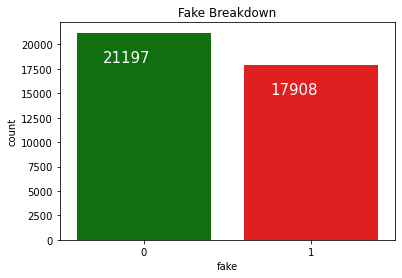

In [13]:
ax = sns.countplot(x='fake', data=news, palette=['g','r'])
ax.set_title('Fake Breakdown')
for i in ax.patches:
    ax.annotate(f'\n{i.get_height()}', (i.get_x() + 0.3, i.get_height()), ha='center', va='top', color='white', size=15)

After removing duplicates, we now have 21197 real news and 17908 fake news articles to work with.

### 2.3 Removing publisher information for real news
<li>With a quick scan of the real news articles in our dataset, we realise that most texts start off with publisher information, specifically Reuters <b>(eg. 'WASHINGTON (Reuters) -')</b>.</li>
<li>We want to be able to generalise our predictions models to articles from any publisher, hence we drop publisher information from our dataset.</li>

In [14]:
with_publisher_info = news['text'].str.contains('^.+ \(Reuters\) - ', regex=True).sum()
print('A total of %d out of %d real news articles contain publisher information' % (with_publisher_info,updated_real))

A total of 19557 out of 21417 real news articles contain publisher information


In [15]:
news['text'] = news['text'].map(lambda x: re.sub(r'^.+ \(Reuters\) - ','',x))
news[news['fake']== 0]['text']

23481    The head of a conservative Republican faction ...
23482    Transgender people will be allowed for the fir...
23483    The special counsel investigation of links bet...
23484    Trump campaign adviser George Papadopoulos tol...
23485    President Donald Trump called on the U.S. Post...
                               ...                        
44893    NATO allies on Tuesday welcomed President Dona...
44894    LexisNexis, a provider of legal, regulatory an...
44895    In the shadow of disused Soviet-era factories ...
44896    Vatican Secretary of State Cardinal Pietro Par...
44897    Indonesia will buy 11 Sukhoi fighter jets wort...
Name: text, Length: 21197, dtype: object

In [16]:
# update 'all_text' column
news['all_text'] = news['title'] + ' ' + news['text'] 

# 3. Exploratory Data Analysis

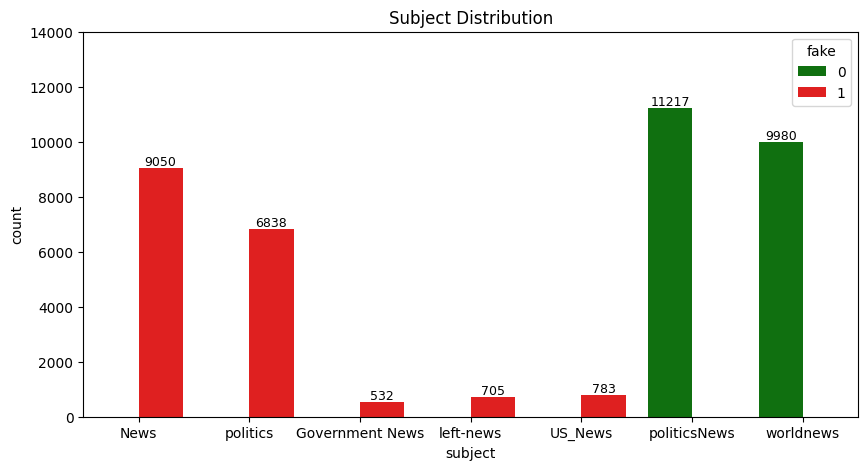

In [17]:
# Subject distribution
plt.figure(figsize=(10,5))
ax = sns.countplot(x='subject', data=news, hue='fake', palette=['g','r'])
ax.set_title('Subject Distribution')
ax.set(ylim=(0, 14000))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height().astype(int)}', (p.get_x()+0.2, p.get_height() + 1000), ha='center', va='top', color='black', size=9)


It appears that all real news fall under either of the subjects 'politicsNews' or 'worldnews', while a significant proportion of fake news are categorised as 'News' or 'politics'.

<AxesSubplot:xlabel='length', ylabel='Count'>

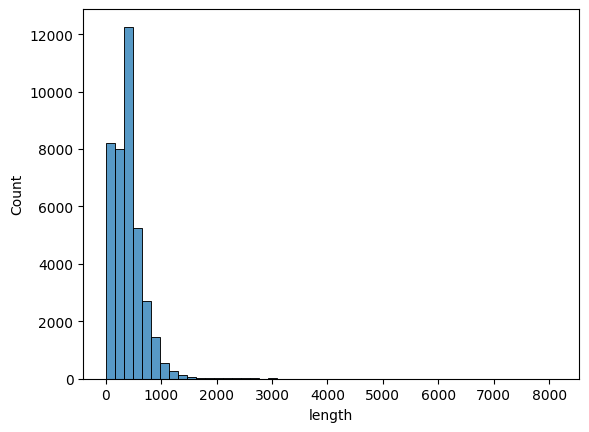

In [18]:
# Overall word length distribution
news['length'] = news['text'].map(lambda x: len(x.split()))
sns.histplot(x='length', data=news, bins = 50)

<AxesSubplot:xlabel='length', ylabel='Count'>

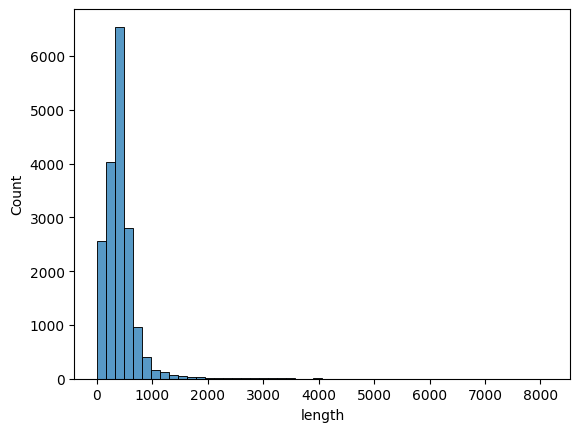

In [19]:
# Fake data distribution of word length
sns.histplot(x='length', data=news.loc[news['fake'] == 1], bins = 50)

<AxesSubplot:xlabel='length', ylabel='Count'>

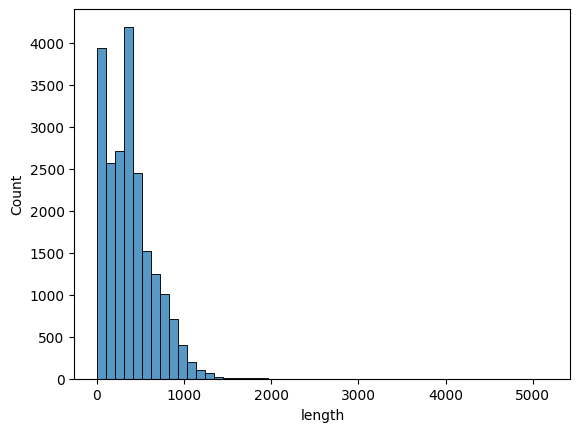

In [20]:
sns.histplot(x='length', data=news.loc[news['fake'] == 0], bins = 50)

In [21]:
from wordcloud import WordCloud, STOPWORDS
#Word Cloud
stopwords = set(STOPWORDS)
def give_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=0
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

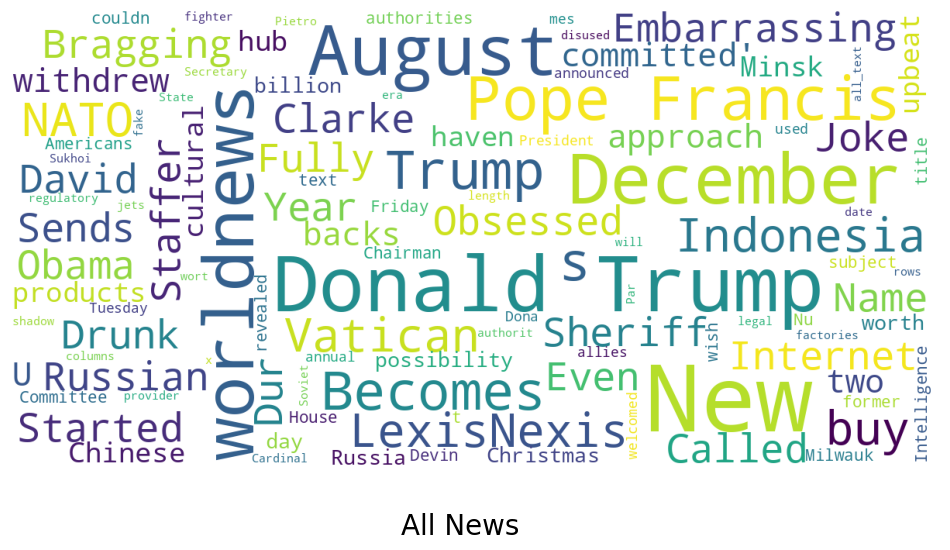

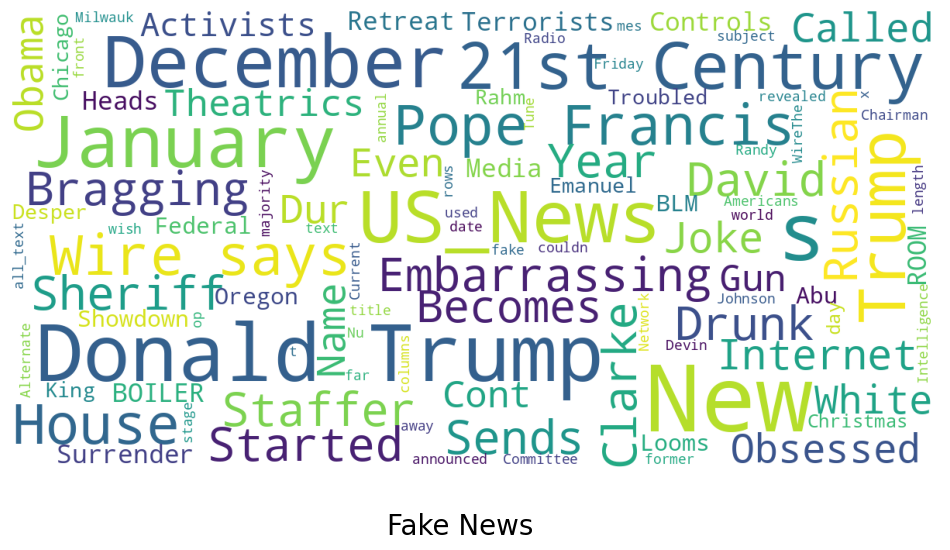

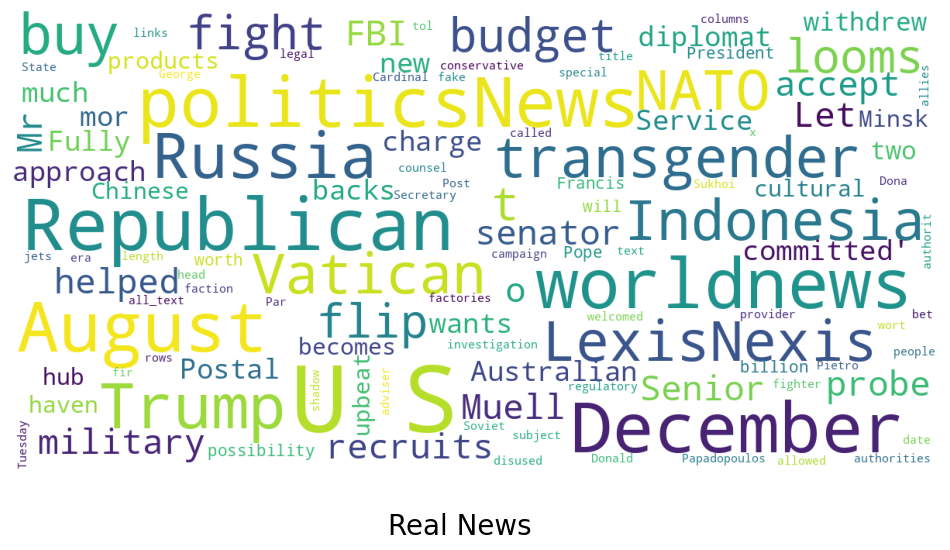

In [22]:
give_wordcloud(news,'All News')
give_wordcloud(news[news['fake'] == 1], 'Fake News')
give_wordcloud(news[news['fake'] == 0], 'Real News')

Fake news shows emotive and loaded language such as 'Drunk' and 'Obsessed', and biased persons such as Donald Trump are often mentioned.
Real news shows distinguished establishments such as 'NATO'and 'Reuters', and does not contain any emotive language. Instead, the words lean more towards factual.

# 4. Testing our hypotheses:
<li></li>
<li></li>
<li></li>

## 4.1 Training a simple RNN model on titles only
https://www.kaggle.com/code/therealcyberlord/fake-news-detection-using-rnn

In [138]:
import string

# pad punctuations with spaces to allow tokenizer to correctly identify words
def padPunctuation(data):
    res = []
    for i in data:
        x = i.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation + "“”‘’…"})) # account for punctuations used in certain text not included in string.punctuation
        res.append(x)
    return res

def cleanText(data):
    cleaned = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        cleaned.append(i)
    return cleaned

In [139]:
from sklearn.model_selection import train_test_split

features = news['title']
target = news['fake']

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

if False:
    X_train = cleanText(X_train)
    X_test = cleanText(X_test)
    
if True:
    X_train = padPunctuation(X_train)
    X_test = padPunctuation(X_test)

In [140]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters='\t\n',
                      lower=False)
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: {}".format(vocab_size))

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Vocab Size: 29561


In [141]:
# get length of longest title and pad all shorter titles to match length
max_len = max([len(x) for x in X_train] + [len(x) for x in X_test])
print("Max Title Length: {}".format(max_len))
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=max_len)

Max Title Length: 56


In [147]:
import math
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, math.ceil(vocab_size**0.25), input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 56, 14)            413854    
                                                                 
 bidirectional_6 (Bidirectio  (None, 56, 128)          10112     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               4640      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [148]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_split=0.1, batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
880/880 [==============================] - 286s 322ms/step - loss: 0.2218 - accuracy: 0.8998 - val_loss: 0.0273 - val_accuracy: 0.9935
Epoch 2/10
880/880 [==============================] - 286s 325ms/step - loss: 0.0232 - accuracy: 0.9950 - val_loss: 0.0126 - val_accuracy: 0.9969
Epoch 3/10
880/880 [==============================] - 284s 323ms/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0132 - val_accuracy: 0.9966
Epoch 4/10
880/880 [==============================] - 285s 324ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0107 - val_accuracy: 0.9976
Epoch 5/10
880/880 [==============================] - 285s 324ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0120 - val_accuracy: 0.9969
Epoch 6/10
880/880 [==============================] - 285s 324ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0123 - val_accuracy: 0.9976


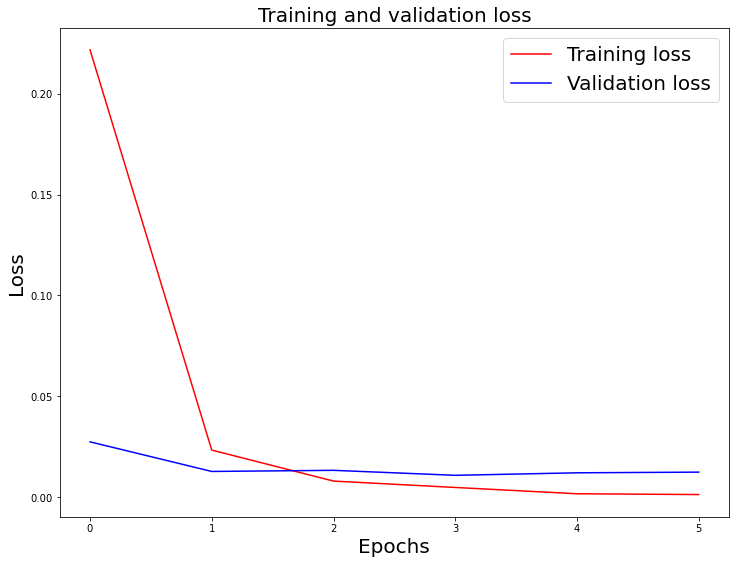

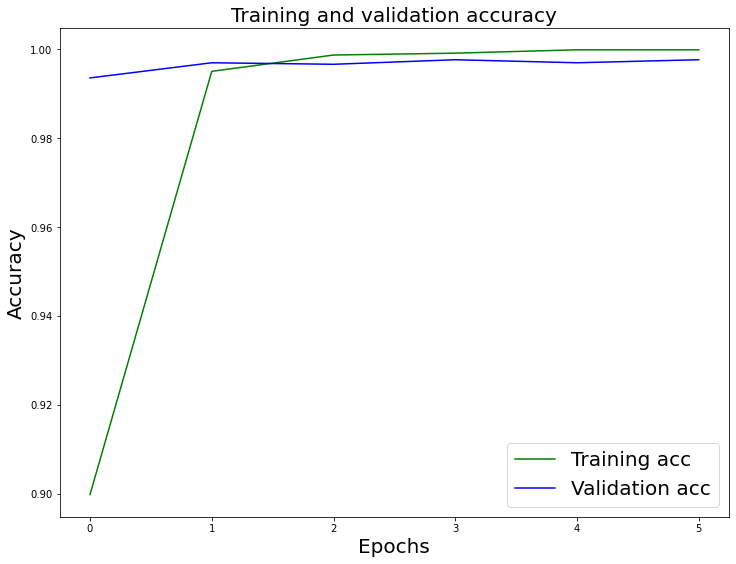

In [151]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
#plt.ylim((0.8,1))
plt.show()

In [45]:
model.evaluate(X_test, y_test)

306/306 [==============================] - 11s 37ms/step - loss: 0.1090 - accuracy: 0.9603


[0.10902247577905655, 0.9603150486946106]

## 4.2 Training an LSTM model on both title and text

### 4.2.1 Training the word2vec model on the dataset

In [17]:
text_df = news[['title','text','all_text','fake']]
text_df.head()

,title,text,all_text,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,Pope Francis Just Called Out Donald Trump Dur...,1


<li>There are certain characteristics distinct to fake news that would be helpful for prediction (eg. number of capitalised words, punctuations etc. However, since word2vec trains better on words in their raw form, we will preprocess the text for this purpose while extracting the distinctive characteristics and train them in another classification model.</li>
<li>Since the use of language and choice of vocabulary differs between real and fake news, we will not lemmatise/stem the words in our corpus</li>


In [18]:
# only words (can have - or ') will be generated as tokens
# create a list of elements each containing a list of words from each article in the corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize

def corpus_to_vect(df_column):
    corpus_tokens = []
    stop_words = set(stopwords.words("english"))
    rtokenizer = RegexpTokenizer(r'[a-zA-Z\'\-]+') # matches any word that contains only letters, hyphens, and apostrophes
    docs = df_column.values
    for doc in docs:
        sents = sent_tokenize(doc)
        doc_tokens = []
        for sent in sents:
            sent_lowered = sent.lower()
            words = rtokenizer.tokenize(sent_lowered) # convert all words to lower case
            filtered = [word.strip() for word in words if word not in stop_words and len(word) > 1] # filter out stopwords
            doc_tokens.extend(filtered)
        corpus_tokens.append(doc_tokens)
    return corpus_tokens

In [21]:
# tokenizing the 'text' column 
tokens = corpus_to_vect(news['all_text'])

In [22]:
 # all tokens generated in the first article
print(tokens[0])

['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald', 'trump', 'wish', 'americans', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'former', 'reality', 'show', 'star', 'one', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'even', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'america', 'donald', 'trump', 'realdonaldtrump', 'december', 'trump', 'tweet', 'went', 'welll', 'expect', 'kind', 'president', 'sends', 'new', 'year', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberis

In [33]:
# training word2vec on the 'text' corpus to form the embedding layer
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
w2v = Word2Vec(
    sentences = tokens,
    vector_size = EMBEDDING_DIM,
    window = 5,
    min_count = 1
)

In [34]:
num = len(w2v.wv)
print('There are a total of %d words in the vocabulary of our trained word2vec model.' % num)

There are a total of 141246 words in the vocabulary of our trained word2vec model.


In [35]:
w2v.wv["donald"]

array([ 1.2320812e-01, -9.8450977e-01,  2.5716963e+00, -9.4508886e-02,
        5.7873905e-01, -3.7638595e+00, -7.0437348e-01,  6.1407536e-01,
        1.3772156e+00,  3.0419827e-04,  5.6898880e-01, -7.6072556e-01,
       -1.6931127e+00, -1.5107560e+00, -2.1375821e+00,  2.3564051e-01,
        3.5969496e-01, -2.2131245e-01,  8.6726564e-01,  4.1670924e-01,
       -1.3825779e-01, -1.9584820e+00,  2.3300731e+00, -4.6611357e+00,
       -1.2920090e+00, -6.6847783e-01,  2.0453839e+00, -1.9635453e+00,
       -6.7274034e-02,  6.0771149e-01, -4.2401962e+00,  6.1150974e-01,
        1.9154652e+00, -1.9049823e-01,  1.2280954e+00,  3.1134775e-02,
       -2.4906898e+00,  6.0605210e-01, -4.2435617e+00, -5.1896157e+00,
       -4.7218418e+00,  1.7213345e+00, -4.1107710e-02, -3.1216240e+00,
       -7.1204960e-01, -7.8709358e-01,  2.8813403e+00,  1.4943942e+00,
       -3.3157535e+00, -7.2914910e-01, -2.8252287e+00,  3.4368578e-01,
       -5.5963784e-01,  1.4308454e+00,  3.8597456e-01, -7.1117109e-01,
      

In [36]:
w2v.wv.most_similar("trump")

[('president-elect', 0.6478136777877808),
 ('president', 0.5311664342880249),
 ('cruz', 0.5222340226173401),
 ('obama', 0.5177943706512451),
 ("trump's", 0.5021876096725464),
 ('however', 0.49624890089035034),
 ('trumpoften', 0.4932865500450134),
 ('romney', 0.4768468141555786),
 ('tomato-tosser', 0.47653263807296753),
 ('actually', 0.4755510687828064)]

### 4.2.2 Preparing the neural network model inputs

In [31]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
token_indices = tokenizer.texts_to_sequences(tokens)

In [32]:
# all token indexes generated from the first article
print(token_indices[0])

[11, 1, 4635, 2630, 8, 31, 4567, 517, 2804, 11, 1, 2283, 134, 1468, 8, 31, 494, 398, 275, 8387, 2965, 8822, 4720, 602, 28, 55, 30, 838, 141, 1092, 6, 324, 32, 4426, 8979, 2581, 9902, 96, 2283, 883, 215, 2965, 8822, 33, 4720, 602, 28, 55, 1468, 3921, 8, 31, 4, 1446, 5850, 878, 261, 31, 73, 32, 4426, 8979, 2581, 9902, 96, 2283, 883, 215, 2965, 8822, 33, 4720, 602, 28, 55, 1468, 3921, 8, 31, 261, 31, 73, 11, 1, 327, 515, 1, 591, 300, 76485, 1058, 638, 4, 4635, 8, 31, 14921, 22, 6511, 5660, 29567, 28272, 1, 1163, 6891, 33, 486, 1228, 13719, 190, 346, 2283, 68, 498, 1468, 8, 31, 6585, 59126, 20730, 59127, 515, 6, 2655, 19430, 37334, 515, 3012, 3, 49, 261, 31, 73, 9, 1232, 18304, 238, 99, 13110, 59128, 59129, 515, 1041, 504, 650, 37, 5, 657, 2083, 657, 5676, 16045, 76486, 515, 2525, 1158, 8822, 8, 34, 2283, 29568, 29568, 515, 42, 1468, 8, 31, 76487, 76488, 76489, 515, 1, 8, 31, 4567, 591, 1468, 8, 31, 72, 37, 2965, 2079, 548, 3088, 80, 746, 11, 1, 327, 515, 314, 8, 1, 34, 1, 2404, 2092, 2965

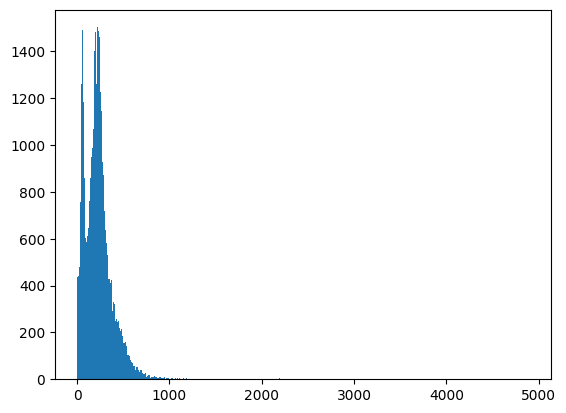

In [33]:
article_lens = np.array([len(index) for index in token_indices])
plt.hist(article_lens, bins=500)
plt.show()

In [34]:
len_1000 = article_lens[article_lens < 1000]
print('%d out of %d articles have less than 1000 words' % (len(len_1000),len(article_lens)))

38936 out of 39105 articles have less than 1000 words


<li>Since the inputs to the neural network have to be of the same size, we have to pad each article in the dataset.</li>
<li>Since the majority of articles have less than 1000 words, we pad shorter news articles and truncate longer articles.</li>

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 1000
padded_tokens = pad_sequences(token_indices, maxlen=maxlen)

In [36]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [37]:
# creating a weight matrix to retain weights learned by word2vec in the embedding layer later on
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # create weight matrix with number of rows = vocab_size and number of columns = number of embedding dimensions
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # for each word in the vocab, store its vector created by the word2vec model
    for word, row_index in vocab.items():
        weight_matrix[row_index] = model.wv[word]
    return weight_matrix

In [38]:
embedding_vectors = get_weight_matrix(w2v, tokenizer.word_index)

# Training the neural network

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

lstm_model = Sequential()
# fixing the embedding layer as non-trainable since these are weights trained and derived from the word2vec model
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

2022-10-22 23:45:15.372129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         14124700  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 14,242,077
Trainable params: 117,377
Non-trainable params: 14,124,700
_________________________________________________________________


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(padded_tokens, text_df['fake']) 

In [42]:
lstm_model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
642/642 [==============================] - 859s 1s/step - loss: 0.1153 - acc: 0.9606 - val_loss: 0.0794 - val_acc: 0.9759
Epoch 2/6
642/642 [==============================] - 760s 1s/step - loss: 0.0951 - acc: 0.9652 - val_loss: 0.0697 - val_acc: 0.9782
Epoch 3/6
642/642 [==============================] - 678s 1s/step - loss: 0.0622 - acc: 0.9797 - val_loss: 0.0533 - val_acc: 0.9810
Epoch 4/6
642/642 [==============================] - 940s 1s/step - loss: 0.0370 - acc: 0.9870 - val_loss: 0.0848 - val_acc: 0.9691
Epoch 5/6
642/642 [==============================] - 801s 1s/step - loss: 0.0241 - acc: 0.9923 - val_loss: 0.1139 - val_acc: 0.9609
Epoch 6/6
642/642 [==============================] - 759s 1s/step - loss: 0.0251 - acc: 0.9921 - val_loss: 0.0236 - val_acc: 0.9930


In [43]:
prediction_probs = lstm_model.predict(X_test)
y_pred = (prediction_probs >= 0.5).astype("int")

306/306 [==============================] - 133s 433ms/step


In [44]:
from sklearn.metrics import classification_report, accuracy_score

accuracy_score(y_test, y_pred)

0.9904878797177048

# Feature Extraction

In [ ]:
news.head()

In [ ]:
news.drop(labels=['title','text'],axis=1,inplace=True)
news.head()

In [ ]:
news.shape

In [ ]:
from sklearn.model_selection import train_test_split
features = news.loc[:,['subject','all_text', 'length']]
target = news.loc[:,'fake']

In [ ]:
fake_news['title']

In [ ]:
real_news['title']